In [ ]:
import os
import pickle
import random
import statistics
import time

import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from prompt_classifier.metrics import evaluate
from prompt_classifier.modeling.dspy_llm import GPT4oMini
from prompt_classifier.modeling.fasttext import FastTextClassifier
from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI
from prompt_classifier.util import create_domain_dataset, train_and_evaluate_model

load_dotenv()
random.seed(1)

In [4]:
providers = ort.get_available_providers()

print(providers)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [ ]:
law_prompts = pd.read_csv("data/processed/law_prompts.csv")
healthcare_prompts = pd.read_csv("data/processed/healthcare_prompts.csv")
finance_prompts = pd.read_csv("data/processed/finance_prompts.csv")

law_dataset = create_domain_dataset(
    law_prompts,
    [healthcare_prompts, finance_prompts]
)

healthcare_dataset = create_domain_dataset(
    healthcare_prompts,
    [law_prompts, finance_prompts]
)

finance_dataset = create_domain_dataset(
    finance_prompts,
    [law_prompts, healthcare_prompts]
)

datasets = {
    "law": law_dataset,
    "healthcare": healthcare_dataset,
    "finance": finance_dataset,
}

In [ ]:
law_prompts_interim = pd.read_csv("data/interim/law_prompts.csv")
healthcare_prompts_interim = pd.read_csv("data/interim/healthcare_prompts.csv")
finance_prompts_interim = pd.read_csv("data/interim/finance_prompts.csv")

law_dataset_interim = create_domain_dataset(
    law_prompts_interim,
    [healthcare_prompts_interim, finance_prompts_interim]
)

healthcare_dataset_interim = create_domain_dataset(
    healthcare_prompts_interim,
    [law_prompts_interim, finance_prompts_interim]
)

finance_dataset_interim = create_domain_dataset(
    finance_prompts_interim,
    [law_prompts_interim, healthcare_prompts_interim]
)

datasets_interim = {
    "law": law_dataset_interim,
    "healthcare": healthcare_dataset_interim,
    "finance": finance_dataset_interim,
}

In [6]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5",
    providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer()

c:\Users\riso\miniconda3\envs\prompt-validation\Lib\site-packages\fastembed\common\onnx_model.py:96: RuntimeWarning: Attempt to set CUDAExecutionProvider failed. Current providers: ['CPUExecutionProvider'].If you are using CUDA 12.x, install onnxruntime-gpu via `pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/`
  warnings.warn(


In [7]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch._dynamo.config.suppress_errors = True # Suppresses warnings in ModernBERT

BAAI-BGE available providers: ['CPUExecutionProvider']
MiniLM available providers: ['CPUExecutionProvider']
Using device: cpu


# GPT and ModernBERT loop using interim data

In [ ]:
for domain, dataset in datasets_interim.items():
    # Split data
    train_data = dataset.sample(n=800)
    test_data = dataset.drop(train_data.index).sample(n=4000)

    # GPT Classifier
    gpt_classifier = GPT4oMini(
        api_key=os.getenv("OPENAI_API_KEY"),
        proxy_url=os.getenv("PROXY_URL"),
        model_name="gpt-4o-mini",
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )

    try:
        # DSPy optimization
        gpt_classifier.optimize_model()

        # Get predictions and metrics for test data
        test_predictions, test_actuals, test_latency = gpt_classifier.predict()
        test_latency = statistics.mean(test_latency)

        test_acc = metrics.accuracy_score(test_actuals, test_predictions)

        # Evaluate and save model
        evaluate(
            predictions=test_predictions,
            true_labels=test_actuals,
            domain=domain,
            model_name="gpt4o-mini",
            embed_model="ada-002",
            cost=gpt_classifier.cost,
            latency=test_latency,
            train_acc=test_acc
        )

        gpt_classifier.save_model(f"models/gpt-4o-mini-{domain}.json")

    except Exception as e:
        print(f"Error running GPT model: {e}")


    try:
        test_data = dataset.sample(n=30_000)
        # ModernBERT Classifier
        bert_classifier = ModernBERTNLI(domain=domain)
        bert_classifier.classifier.model.to("cuda")

        # Test predictions
        test_predictions = []
        test_times = []
        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            start_time = time.perf_counter_ns()
            pred = bert_classifier.predict(row["prompt"])
            test_predictions.append(pred)
            test_times.append(time.perf_counter_ns() - start_time)

        print(test_predictions)
        test_acc = metrics.accuracy_score(test_data["label"], test_predictions)
        mean_prediction_time = statistics.mean(test_times)

        # Evaluate ModernBERT
        evaluate(
            predictions=test_predictions,
            true_labels=test_data["label"],
            domain=domain,
            model_name="modernbert",
            embed_model="bert-base",
            latency=mean_prediction_time,
            train_acc=test_acc
        )
    except Exception as e:
        print(f"Error running ModernBERT model: {e}")

# SVM, fastText and XGBoost loop using processed data

In [ ]:
embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

In [10]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

BAAI-BGE available providers: ['CPUExecutionProvider']
MiniLM available providers: ['CPUExecutionProvider']


100%|██████████| 9000/9000 [00:00<00:00, 13562.98it/s]


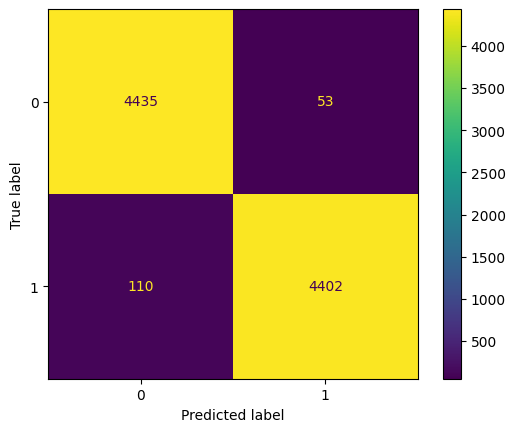

In [ ]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.7).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    try:
        fasttext_classifier = FastTextClassifier(train_data=train_data, test_data=test_data)
        fasttext_classifier.train()

        train_predictions = []
        for _, row in train_data.iterrows():
            query = str(row["prompt"]).replace("\n", "")
            prediction = fasttext_classifier.model.predict(query)
            train_predictions.append(1 if prediction[0][0] == "__label__1" else 0)

        train_acc = metrics.accuracy_score(train_data["label"], train_predictions)

        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            text = str(row["prompt"])
            query = text.replace("\n", "")

            start_time = time.perf_counter_ns()
            prediction = fasttext_classifier.model.predict(query)
            end_time = time.perf_counter_ns()

            prediction_times.append(end_time - start_time)

            if prediction[0][0] == "__label__1":
                predictions.append(1)
            else:
                predictions.append(0)

            actuals.append(row["label"])

        mean_prediction_time = statistics.mean(prediction_times)

        evaluate(
            predictions,
            true_labels=actuals,
            domain=domain,
            model_name="fastText",
            embed_model="fastText",
            latency=mean_prediction_time,
            train_acc=train_acc,
        )

        fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")
    except Exception as e:
        print(f"Error running fastText model: {e}")

    for model_name, embedding_model in embedding_models.items():
        embed_times: float = None

        # Add timing for embedding creation
        if model_name == "tf_idf":
            embedding_model.fit(train_data["prompt"])

            with open(f"models/tfidf_{domain}.pkl", "wb") as f:
                pickle.dump(embedding_model, f)

            # Time the transform process for training data
            start_time = time.perf_counter_ns()
            train_embeds = embedding_model.transform(train_data["prompt"])
            test_embeds = embedding_model.transform(test_data["prompt"])
            end_time = time.perf_counter_ns()
            embed_times = end_time - start_time
        else:
            # Time the embedding process for training data
            start_time = time.perf_counter_ns()
            train_embeds = np.array(list(embedding_model.embed(train_data["prompt"])))
            test_embeds = np.array(list(embedding_model.embed(test_data["prompt"])))
            end_time = time.perf_counter_ns()
            embed_times = end_time - start_time

        mean_embed_time = embed_times / len(train_data + test_data)

        try:
            # Train and evaluate SVM model
            train_and_evaluate_model(
                model_name="SVM",
                train_embeds=train_embeds,
                test_embeds=test_embeds,
                train_labels=train_data["label"],
                test_labels=test_data["label"],
                domain=domain,
                embed_model=model_name,
                save_path=f"models/SVM_{domain}_{model_name}.pkl",
                embedding_time=mean_embed_time  # Pass the embedding time
            )
        except Exception as e:
            print(f"Error running SVM model: {e}")

        try:
            # Train and evaluate XGBoost model
            train_and_evaluate_model(
                model_name="XGBoost",
                train_embeds=train_embeds,
                test_embeds=test_embeds,
                train_labels=train_data["label"],
                test_labels=test_data["label"],
                domain=domain,
                embed_model=model_name,
                save_path=f"models/XGBoost_{domain}_{model_name}.json",
                embedding_time=mean_embed_time  # Pass the embedding time
            )
        except Exception as e:
            print(f"Error running XGBoost model: {e}")